In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit_cst_pro as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 0.01, 900]


times = np.linspace(20, 75, 56)

df = pd.read_csv('2017-03-16_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())
org_values = org_values[:56,:]


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((56,4))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 4
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 3
New dimension: 7


Create uniform log prior

In [5]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 0.00001
prior_arr_upper[1] = 0.1
prior_arr_lower[2] = 1
prior_arr_upper[2] = 4000
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_3528/3449605926.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 1000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.3
1     507     0:01.4
2     978     0:02.5
3     1455    0:03.6
20    8328    0:18.8
40    14097   0:31.8
60    19716   0:44.5
80    25512   0:57.5
100   31218   1:10.4
120   36777   1:22.9
140   42564   1:36.3
160   48255   1:49.3
180   53961   2:02.1
200   59388   2:14.3
220   65331   2:27.5
240   70869   2:40.0
260   76524   2:52.8
280   82134   3:05.4
300   87744   3:18.2
320   93216   3:31.4
340   98766   3:45.3
360   104520   3:59.2
380   110208   4:13.7
400   116169   4:28.4
420   121863   4:42.6
440   127716   4:57.1
460   132846   5:10.3
480   138516   5:24.0
500   144192   5:38.4
520   149574   5:51.8
540   155499   6:06.3
560   161397   6:20.5
580   167100   6:34.7
600   172785   6:49.2
620   178296   7:03.2
640   183618   7:16.1
660   189096   7:29.8
680   194913   7:44.5
700   200586   7:58.8
720   206421   8:13.5
740   212106   8:27.0
760   218160   8:

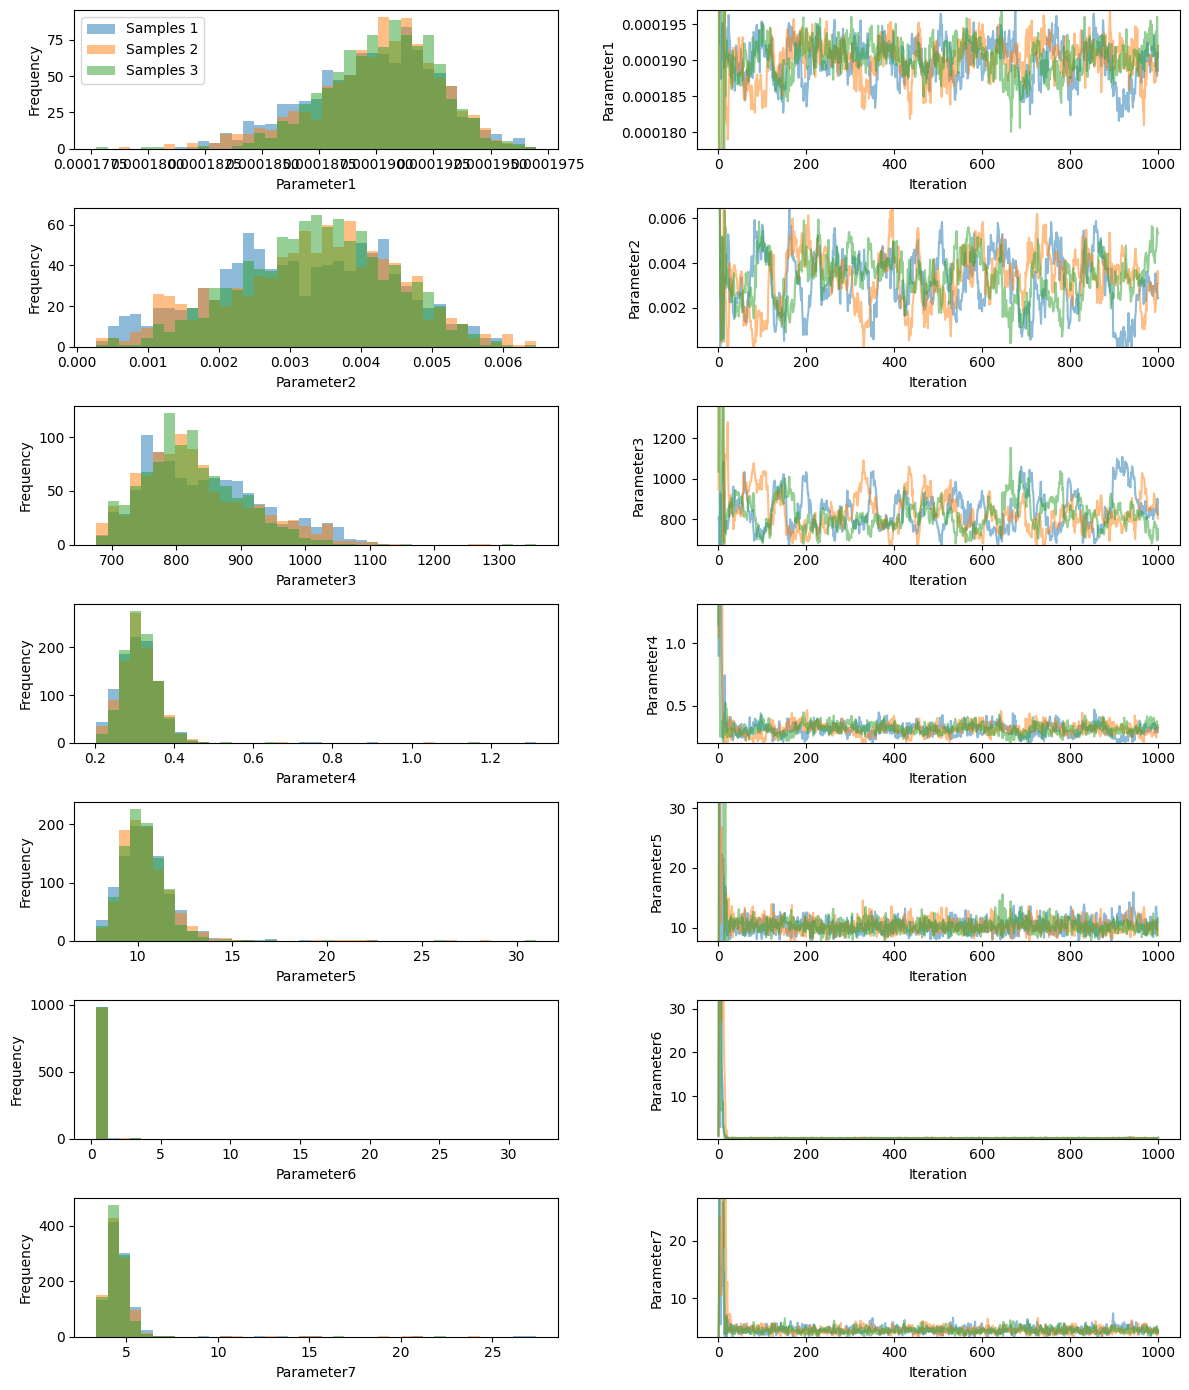

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [22]:

y0 = np.array([0.0003, 0.01, 1100,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.01, 1100,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.001, 1100,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.01, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.001, 1100,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.01, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.001, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.001, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pints/_optimisers/_xnes.py:82: UserWarning: All points requested by XNES are outside the boundaries.
  warnings.warn(


Estimated parameters:
[1.90852348e-04 3.59215208e-03 8.03972198e+02 3.13909521e-01
 9.84409631e+00 4.76314105e-01 4.30503557e+00]
Estimated parameters:
[1.90852345e-04 3.59214980e-03 8.03972338e+02 3.13909458e-01
 9.84409713e+00 4.76314169e-01 4.30503572e+00]
Estimated parameters:
[1.90852347e-04 3.59215151e-03 8.03972231e+02 3.13909510e-01
 9.84409576e+00 4.76314106e-01 4.30503577e+00]
Estimated parameters:
[1.90852340e-04 3.59214760e-03 8.03972485e+02 3.13909406e-01
 9.84409757e+00 4.76314178e-01 4.30503649e+00]
Estimated parameters:
[1.90852347e-04 3.59215106e-03 8.03972267e+02 3.13909485e-01
 9.84409658e+00 4.76314139e-01 4.30503618e+00]
Estimated parameters:
[1.90852345e-04 3.59215018e-03 8.03972319e+02 3.13909464e-01
 9.84409667e+00 4.76314104e-01 4.30503591e+00]
Estimated parameters:
[1.90852348e-04 3.59215093e-03 8.03972256e+02 3.13909506e-01
 9.84409678e+00 4.76314159e-01 4.30503569e+00]
Estimated parameters:
[1.04874902e-04 1.16175266e-02 4.21529505e+02 1.87273178e+01
 4.9185

In [9]:
print(log_likelihood([1.90852342e-04, 3.59214785e-03, 8.03972467e+02, 3.13909385e-01,
 9.84409670e+00, 4.76314121e-01, 4.30503623e+00]))

AIC = 2*7 - 2*log_likelihood([1.90852342e-04, 3.59214785e-03, 8.03972467e+02, 3.13909385e-01,
 9.84409670e+00, 4.76314121e-01, 4.30503623e+00])

print(AIC)

-421.2366610353402
856.4733220706804


In [10]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 7)
[1.95022794e-04 5.67278731e-03 7.00586236e+02 3.65465499e-01
 1.14020777e+01 4.32590397e-01 3.80525999e+00]
[[1.95022794e-04 5.67278731e-03 7.00586236e+02 ... 1.14020777e+01
  4.32590397e-01 3.80525999e+00]
 [1.91947274e-04 5.65542682e-03 7.08415851e+02 ... 1.14071383e+01
  4.25043171e-01 3.92480826e+00]
 [1.92191764e-04 4.86741747e-03 7.46500269e+02 ... 1.01620508e+01
  4.22799138e-01 3.67600936e+00]
 ...
 [1.87842573e-04 2.94720627e-03 8.76606389e+02 ... 9.65175201e+00
  5.56977374e-01 5.15677133e+00]
 [1.91080545e-04 2.41474266e-03 9.01876914e+02 ... 1.06514064e+01
  4.69776606e-01 3.93220337e+00]
 [1.88526397e-04 2.45095561e-03 8.23918289e+02 ... 1.09203448e+01
  6.02427449e-01 4.31949681e+00]]


In [11]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


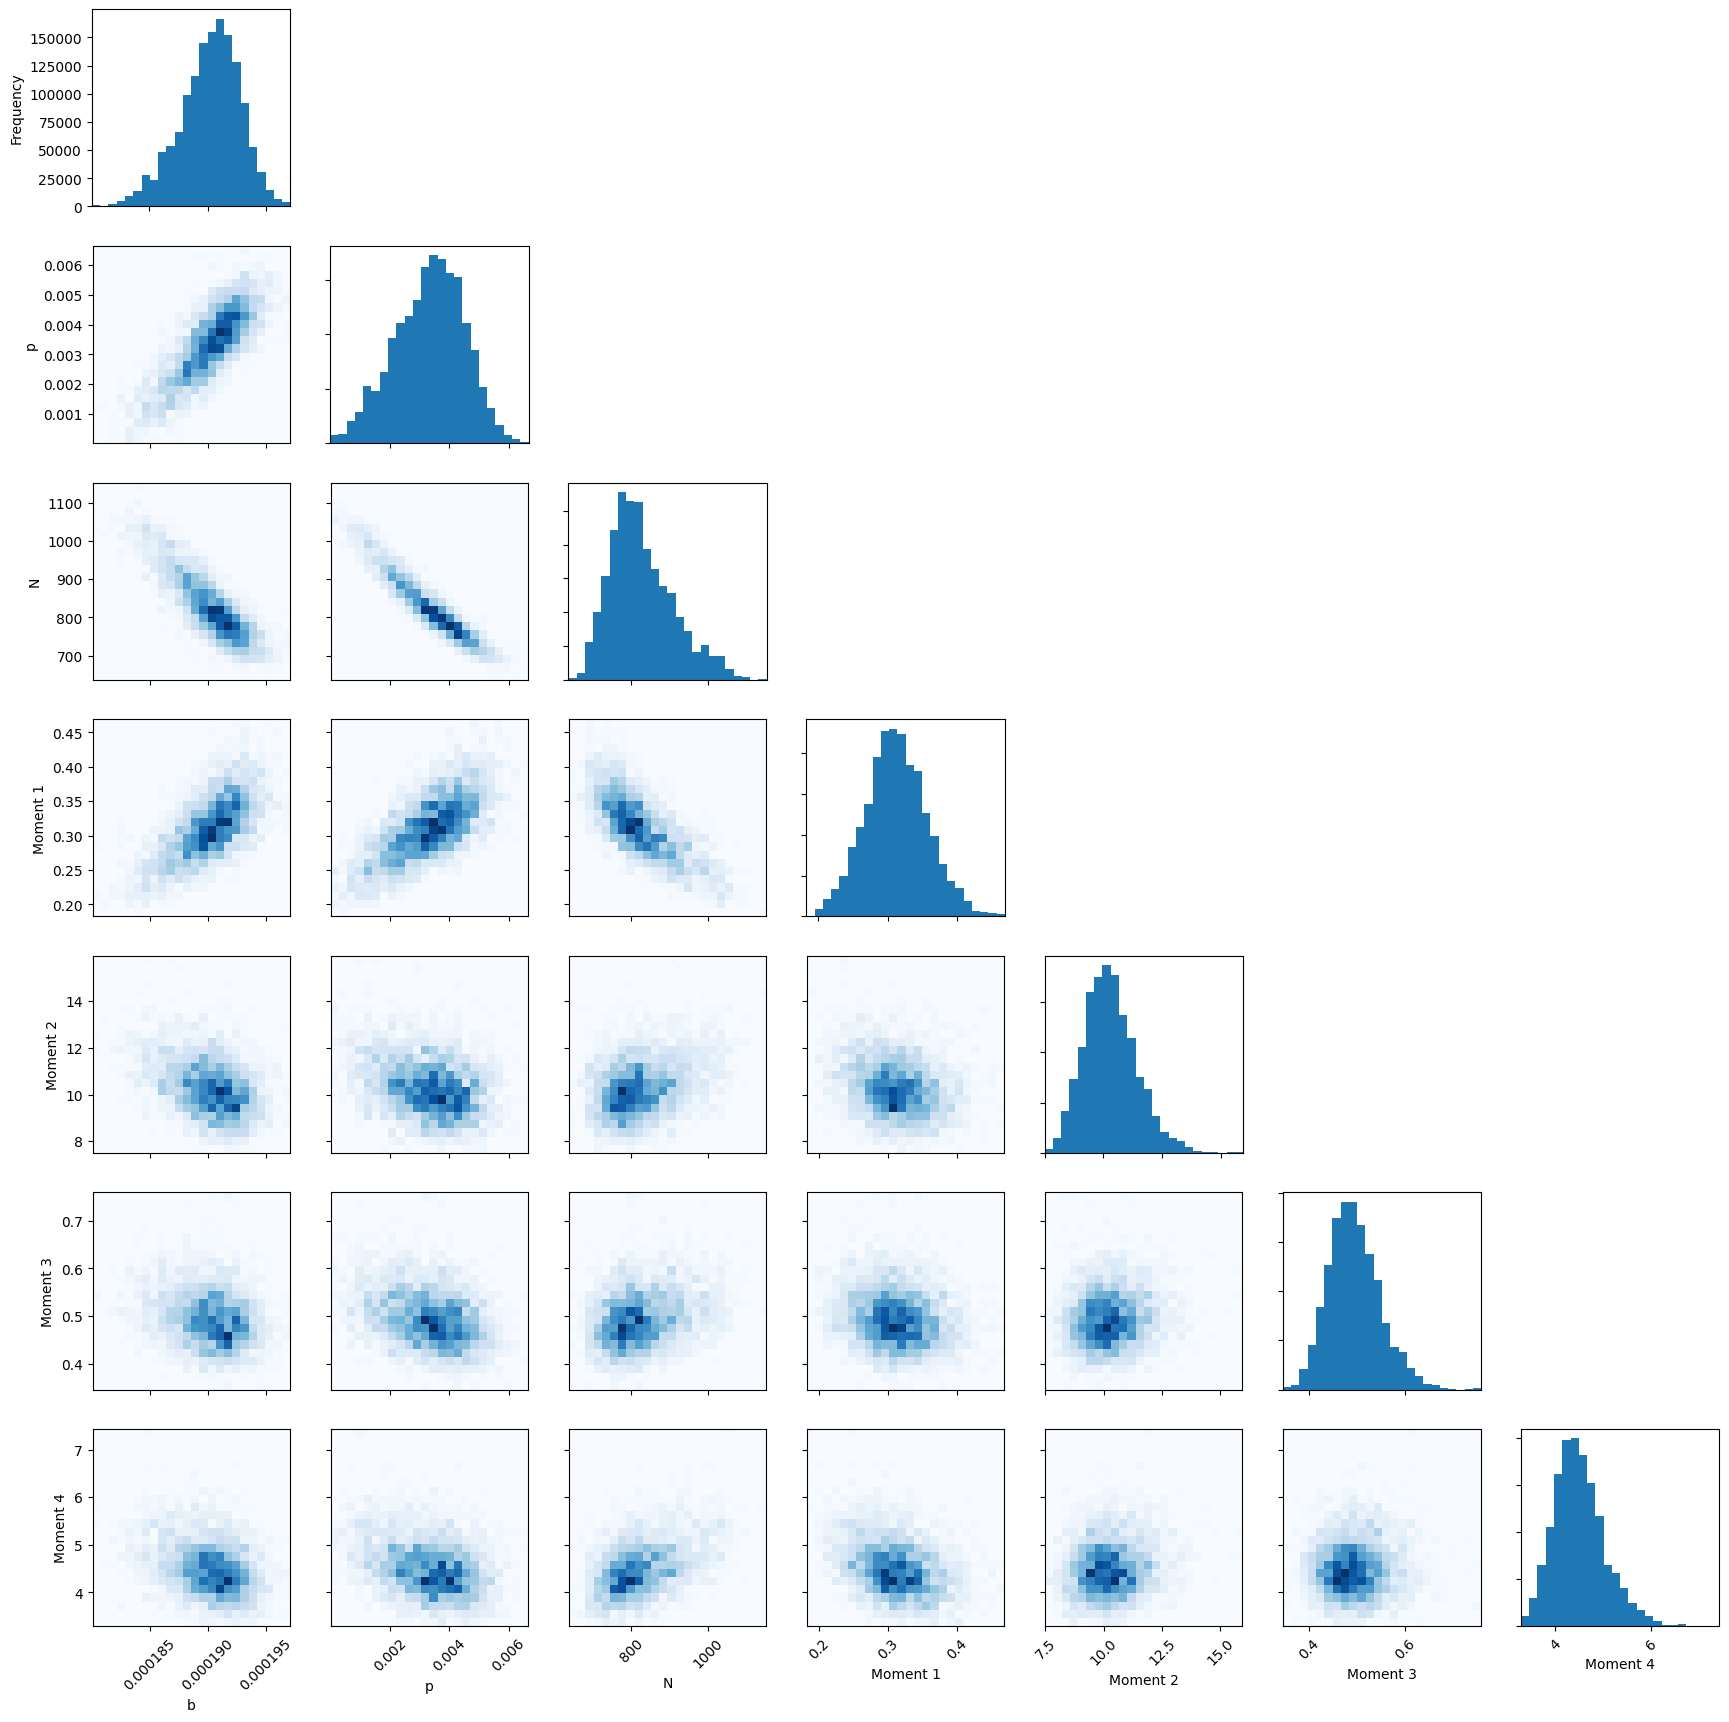

In [12]:


parameter_names = ["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.show()

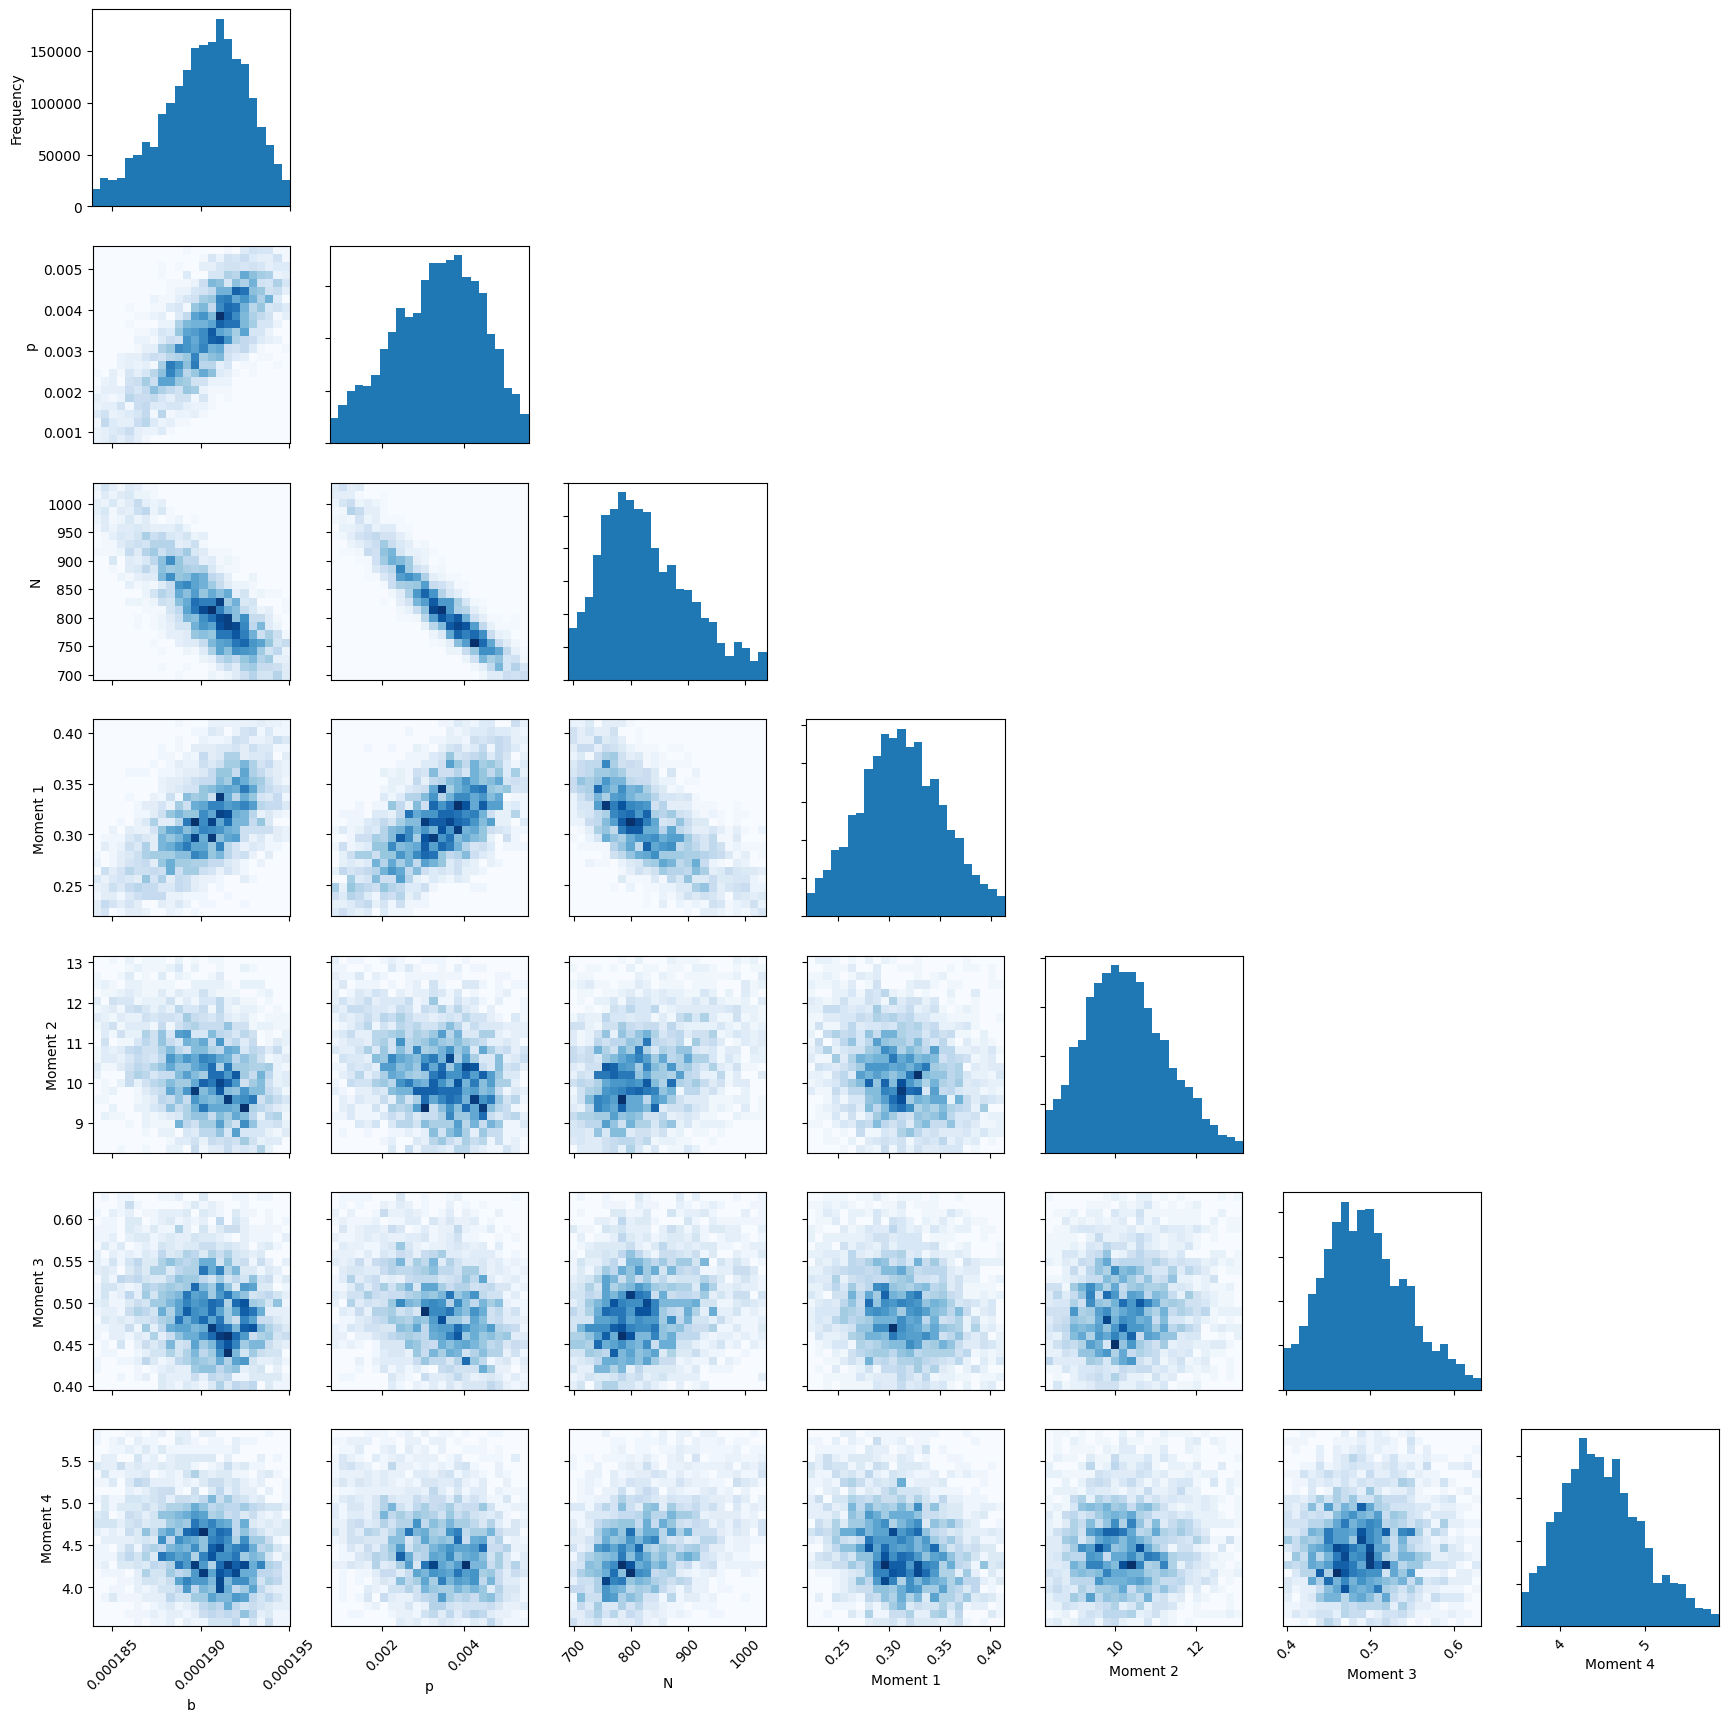

In [13]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"],
                    n_percentiles=97)
                    
plt.show()

In [15]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
--------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
b         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.02    79.11   0.12
p         0.00    0.00    0.00    0.00    0.00    0.00    0.01     1.02    55.13   0.08
N         829.67  83.64   699.46  767.58  820.78  876.90  1033.86  1.03    54.84   0.08
Moment 1  0.31    0.04    0.23    0.28    0.31    0.34    0.41     1.01    98.86   0.15
Moment 2  10.36   1.16    8.40    9.57    10.22   11.05   13.02    1.01    233.50  0.35
Moment 3  0.50    0.06    0.40    0.46    0.49    0.53    0.62     1.00    283.44  0.42
Moment 4  4.51    0.54    3.60    4.14    4.46    4.82    5.70     1.01    258.79  0.38


In [16]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [17]:

parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean     std.      2.5%      25%       50%      75%       97.5%     rhat    ess    ess per sec.
--------  -------  --------  --------  --------  -------  --------  --------  ------  -----  --------------
b         0.00019  2.64e-06  0.000184  0.000189  0.00019  0.000192  0.000195  1.02    79.1   0.117
p         0.00331  0.00117   0.000784  0.00257   0.00337  0.00418   0.0054    1.02    55.1   0.0815
N         830      83.6      699       768       821      877       1.03e+03  1.03    54.8   0.0811
Moment 1  0.312    0.0448    0.228     0.282     0.311    0.341     0.406     1.01    98.9   0.146
Moment 2  10.4     1.16      8.4       9.57      10.2     11        13        1.01    233    0.345
Moment 3  0.496    0.0552    0.401     0.458     0.49     0.526     0.618     1       283    0.419
Moment 4  4.51     0.537     3.6       4.14      4.46     4.82      5.7       1.01    259    0.383


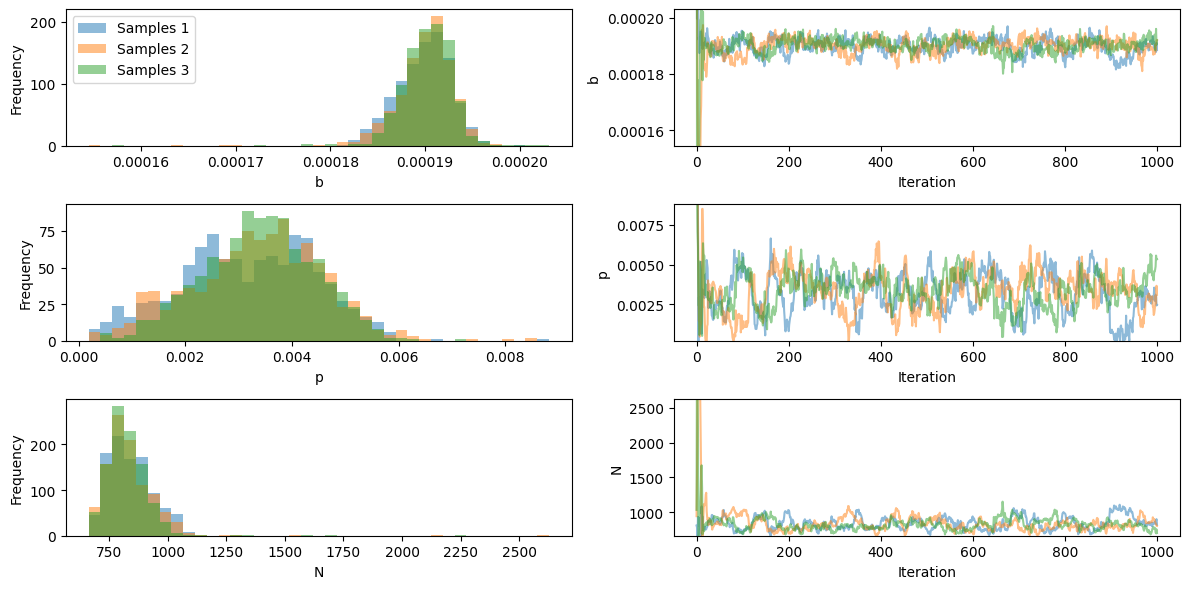

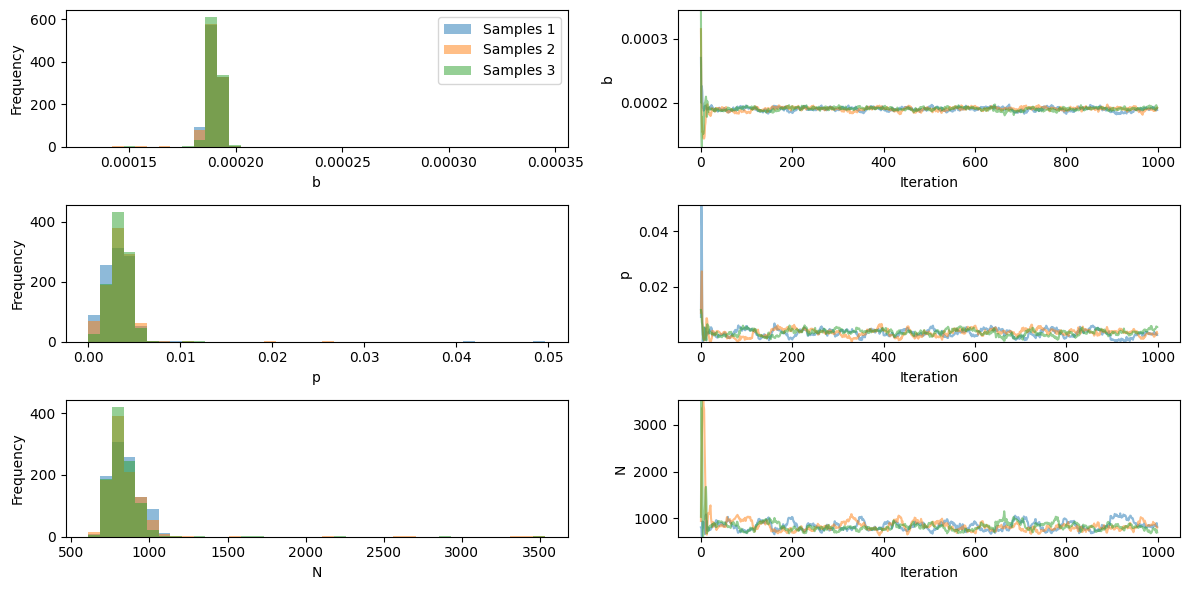

In [18]:
pints.plot.trace(chains[:,:,[0,1,2]], n_percentiles=99.5, parameter_names=["b","p","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1,2]], parameter_names=["b","p","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()

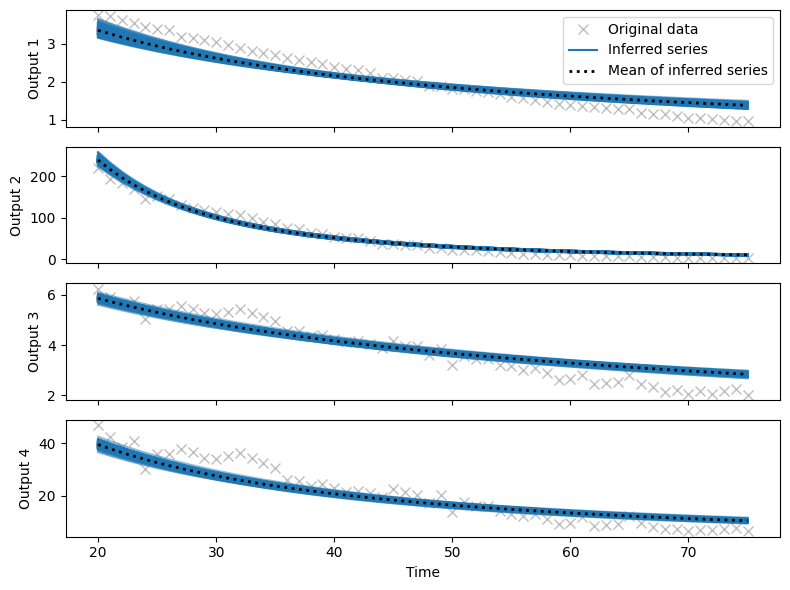

In [19]:
fig, axes = pints.plot.series(AllChains, problem)

# # Customise the plot, and add the original, noise-free data
# fig.set_size_inches(12,4.5)
# plt.plot(times, org_values, c='orange', label='Noise-free data')
# plt.legend()
# plt.show()

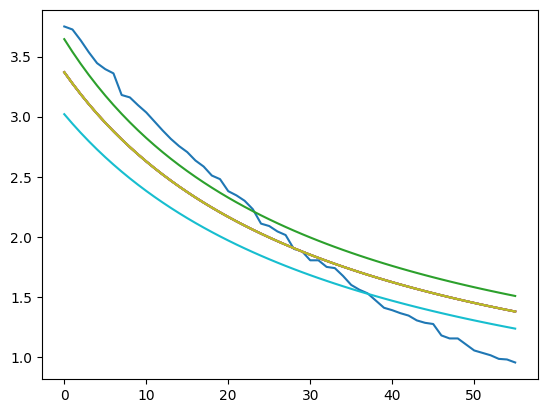

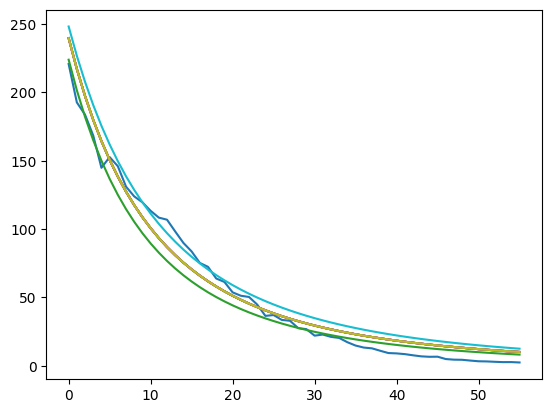

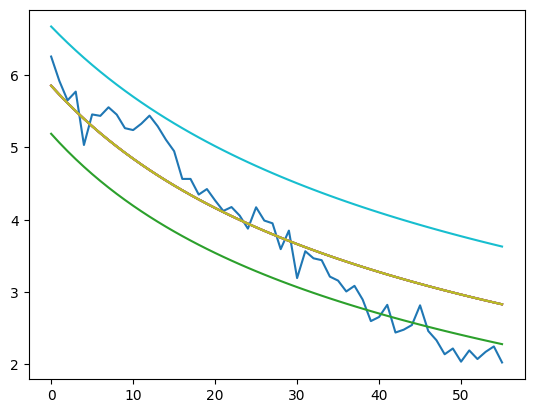

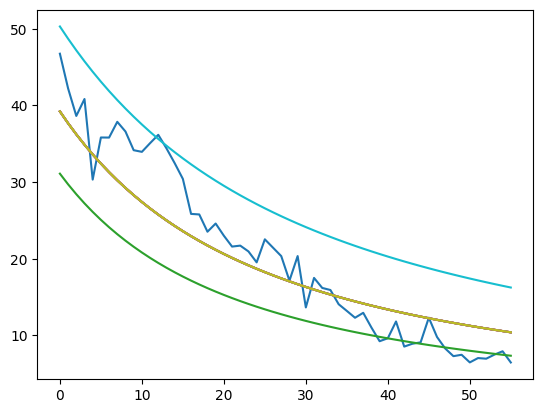

In [20]:



data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):
means = results.mean()[[0,1,2]]
st_devs = results.std()[[0,1,2]]

CI_0 = means

CI_1 = means + 2*st_devs

CI_2 = means
CI_2[0] += 2*st_devs[0]
CI_2[1] += 2*st_devs[1] 
CI_2[2] -= 2*st_devs[2]

CI_3 = means
CI_3[0] += 2*st_devs[0]
CI_3[1] -= 2*st_devs[1] 
CI_3[2] += 2*st_devs[2]

CI_4 = means
CI_4[0] -= 2*st_devs[0]
CI_4[1] += 2*st_devs[1] 
CI_4[2] += 2*st_devs[2]

CI_5 = means
CI_5[0] += 2*st_devs[0]
CI_5[1] -= 2*st_devs[1] 
CI_5[2] -= 2*st_devs[2]

CI_6 = means
CI_6[0] -= 2*st_devs[0]
CI_6[1] += 2*st_devs[1] 
CI_6[2] -= 2*st_devs[2]

CI_7 = means
CI_7[0] -= 2*st_devs[0]
CI_7[1] -= 2*st_devs[1] 
CI_7[2] += 2*st_devs[2] 

CI_8 = means - 2*st_devs

values_0 = model.simulate(CI_0, times)
values_1 = model.simulate(CI_1, times)
values_2 = model.simulate(CI_2, times)
values_3 = model.simulate(CI_3, times)
values_4 = model.simulate(CI_4, times)
values_5 = model.simulate(CI_5, times)
values_6 = model.simulate(CI_6, times)
values_7 = model.simulate(CI_7, times)
values_8 = model.simulate(CI_8, times)
# print(np.shape(values))

plt.plot(data_mean)
plt.plot(values_0[:,0])
plt.plot(values_1[:,0])
plt.plot(values_2[:,0])
plt.plot(values_3[:,0])
plt.plot(values_4[:,0])
plt.plot(values_5[:,0])
plt.plot(values_6[:,0])
plt.plot(values_7[:,0])
plt.plot(values_8[:,0])
plt.show()



plt.plot(data_variance)
plt.plot(values_0[:,1])
plt.plot(values_1[:,1])
plt.plot(values_2[:,1])
plt.plot(values_3[:,1])
plt.plot(values_4[:,1])
plt.plot(values_5[:,1])
plt.plot(values_6[:,1])
plt.plot(values_7[:,1])
plt.plot(values_8[:,1])
plt.show()


plt.plot(data_skewness)
plt.plot(values_0[:,2])
plt.plot(values_1[:,2])
plt.plot(values_2[:,2])
plt.plot(values_3[:,2])
plt.plot(values_4[:,2])
plt.plot(values_5[:,2])
plt.plot(values_6[:,2])
plt.plot(values_7[:,2])
plt.plot(values_8[:,2])
plt.show()

plt.plot(data_kurtosis)
plt.plot(values_0[:,3])
plt.plot(values_1[:,3])
plt.plot(values_2[:,3])
plt.plot(values_3[:,3])
plt.plot(values_4[:,3])
plt.plot(values_5[:,3])
plt.plot(values_6[:,3])
plt.plot(values_7[:,3])
plt.plot(values_8[:,3])
plt.show()

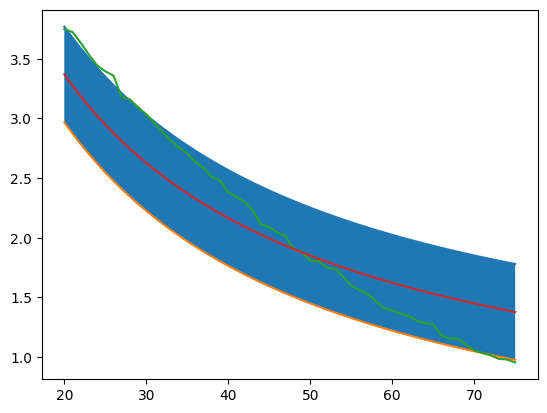

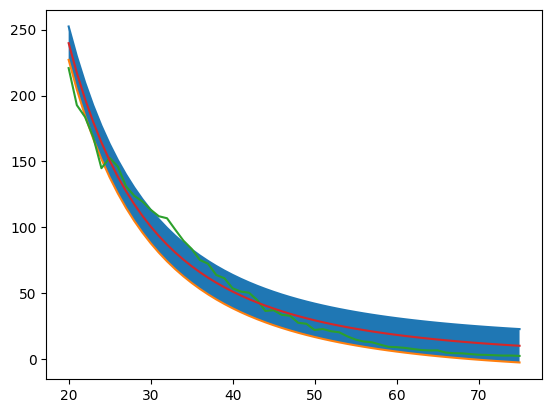

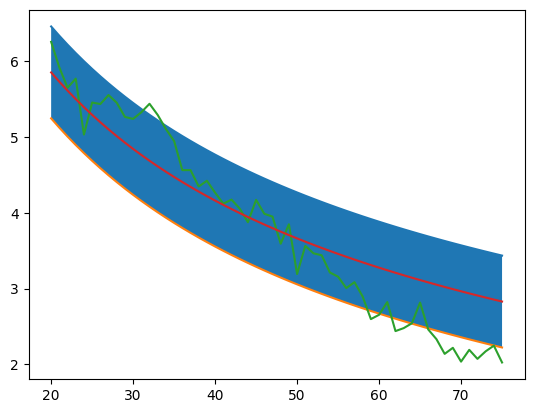

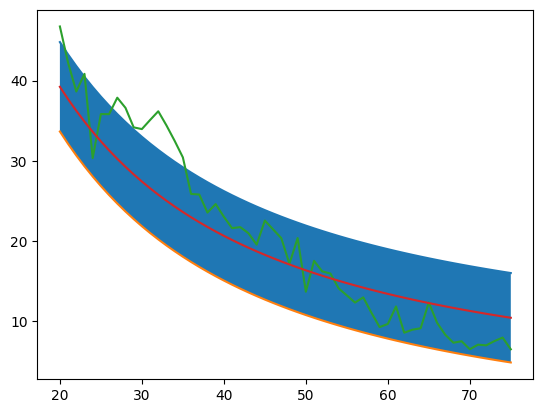

In [21]:

data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):
means = results.mean()[[0,1,2]]
st_devs = results.std()[[0,1,2]]

mean_CI = results.mean()[[3,4,5,6]]
st_devs_CI = results.std()[[3,4,5,6]]

CI_0 = means


values_0 = model.simulate(CI_0, times)
x=np.linspace(20,75,56)

y1=values_0[:,0]+mean_CI[0]+2*st_devs_CI[0]
y2=values_0[:,0]-mean_CI[0]-2*st_devs_CI[0]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_mean)
plt.plot(x,values_0[:,0])
plt.show()

y1=values_0[:,1]+mean_CI[1]+2*st_devs_CI[1]
y2=values_0[:,1]-mean_CI[1]-2*st_devs_CI[1]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_variance)
plt.plot(x,values_0[:,1])
plt.show()

y1=values_0[:,2]+mean_CI[2]+2*st_devs_CI[2]
y2=values_0[:,2]-mean_CI[2]-2*st_devs_CI[2]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_skewness)
plt.plot(x,values_0[:,2])
plt.show()


y1=values_0[:,3]+mean_CI[3]+2*st_devs_CI[3]
y2=values_0[:,3]-mean_CI[3]-2*st_devs_CI[3]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_kurtosis)
plt.plot(x,values_0[:,3])
plt.show()
